TODO:


1.   "play" with the threshold, calculate it according to the mean of the others, or some other method, to determine the best one
2.   Try to incorporate the methods mentioned in the tips in the task description



# Given code, copied from: "project_util.py"

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Resize
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

#our imports
from torchvision.transforms import Normalize
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.distance as spd
from scipy.stats import weibull_min
from torch import optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

eval_mode = False  # Set to True for evaluation-only mode

baseline_model_path = "./baseline_model.pth"
osr_model_path = "./osr_model.pth"

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device)
    return model

In [29]:
# OSR Dataset template
class CombinedDataset(Dataset):
    def __init__(self, mnist, ood, transform_mnist=None, transform_ood=None):
        self.mnist = mnist
        self.ood = ood
        # transforms could be defined either here or when you init each dataset.
        self.transform_mnist = transform_mnist
        self.transform_ood = transform_ood

    def __len__(self):
        # combined length of MNIST and OOD
        return len(self.mnist) + len(self.ood)

    def __getitem__(self, idx):
        if idx < len(self.mnist):
            # if index is within the range of MNIST, return MNIST data and label
            data, label = self.mnist[idx]
            if self.transform_mnist:
                data = self.transform_mnist(data)
            return data, label
        else:
            # if index is beyond the range of MNIST, return OOD data and 10 as label
            data, _ = self.ood[idx - len(self.mnist)]  # adjust index for OOD
            if self.transform_ood:
                data = self.transform_ood(data)
            return data, 10  # OOD label is always 10

def eval_model(model, data_loader, device, threshold): #EY- changed to incorporate threshold
    model.eval()
    correct_mnist, total_mnist = 0, 0
    correct_ood, total_ood = 0, 0
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            data = data.view(-1, 28 * 28)
            recon, preds, embeddings = model(data)

            # Calculate reconstruction error
            recon_error = torch.mean((recon - data) ** 2, dim=1)

            # Classification predictions
            probas, y_pred = torch.max(preds, 1)

            # OOD Detection using reconstruction error
            is_ood = recon_error > threshold
            y_pred[is_ood] = 10  # Classify as "Unknown"

            # Evaluate MNIST and OOD accuracy
            mask_mnist = labels < 10
            mask_ood = labels == 10

            total_mnist += mask_mnist.sum().item()
            total_ood += mask_ood.sum().item()

            correct_mnist += (y_pred[mask_mnist] == labels[mask_mnist]).sum().item()
            correct_ood += (y_pred[mask_ood] == labels[mask_ood]).sum().item()

            total_correct += (y_pred == labels).sum().item()
            total_samples += labels.size(0)

    acc_mnist = correct_mnist / total_mnist if total_mnist > 0 else 0
    acc_ood = correct_ood / total_ood if total_ood > 0 else 0
    acc_total = total_correct / total_samples
    return acc_mnist, acc_ood, acc_total

# Our Implementation:

## The Model

In [30]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.code_size = 2
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64,
            self.code_size))
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            #nn.Tanh()) //optional, this is an activation func on the output of decoder, sometimes needed and sometimes not
        )

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector) # reconstructed vector
        return recon, encoded_vector


class ML_autoencoder_OSR(autoencoder):
    def __init__(self):
        super(ML_autoencoder_OSR, self).__init__()
        self.n_classes = 11  # 10 MNIST classes + 1 for "Unknown"
        self.clf = nn.Sequential(
            nn.Linear(self.code_size, self.n_classes),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        preds = self.clf(encoded_vector)
        return recon, preds, encoded_vector


input_size = 784
hidden_sizes = [128, 64]
output_size = 10
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.input = nn.Linear(input_size, hidden_sizes[0])
      self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
      self.hidden2 = nn.Linear(hidden_sizes[1], output_size)

    # x represents our data
    def forward(self, x):
      x = self.input(x)
      x = F.relu(x)
      x = self.hidden1(x)
      x = F.relu(x)
      # sometimes refered to as 'logits'
      x = self.hidden2(x)
      output = F.log_softmax(x, dim=1)
      return output

baseline_model = Net().to(device)

## Data preparation

In [31]:
num_epochs = 300
batch_size = 1024
learning_rate = 0.001

osr_mapping = {i: i for i in range(10)}
osr_mapping[10] = "Unknown"

# Train on a random subset of 1k examples
transform = transforms.Compose([Resize((28, 28)),ToTensor(),Normalize((0.5,), (0.5,))])

ood_transform = transforms.Compose([Resize((28, 28)), transforms.Grayscale(num_output_channels=1), ToTensor(), Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# CIFAR10 as OOD
ood_cifar = CIFAR10(root='./data', train=False, download=True, transform=ood_transform)
ood_cifar.targets = [10] * len(ood_cifar)  # Set all labels to 10 ("Unknown")

# FashionMNIST as OOD
ood_fashion = FashionMNIST(root='./data', train=False, download=True, transform=ood_transform)
ood_fashion.targets = [10] * len(ood_fashion)  # Set all labels to 10 ("Unknown")

# Combined OOD dataset
combined_ood = torch.utils.data.ConcatDataset([ood_cifar, ood_fashion])

# Step 4: Combine MNIST and OOD for OSR evaluation
combined_ds = CombinedDataset(testset, combined_ood)

N = 1000
torch.manual_seed(0)
np.random.seed(0)

# sample indicies
train_size = len(trainset)
train_idx = np.arange(train_size)
train_subset_idx = np.random.choice(train_idx, N)
train_subset_sampler = SubsetRandomSampler(train_subset_idx)

trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_subset_sampler)

Files already downloaded and verified


## Training

In [32]:
def train_baseline_model(model, trainloader, num_epochs=10):
  epoch_loss_list = []
  criterion = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  for epoch in tqdm(range(num_epochs), desc="Training MNIST MLP"):  # loop over the dataset multiple times
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          # [batch_sizex1x28x28 -> 784]
          inputs = inputs.view(inputs.shape[0], -1)
          # mode to device/cuda
          inputs, labels = inputs.to(device), labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
      epoch_loss_list.append(running_loss)

  plt.plot(epoch_loss_list)
  plt.grid()
  plt.xlabel("Batch num")
  plt.ylabel("Loss")
  plt.title("MNIST MLP Loss over epochs")
  plt.show()
  return model


def train_OSR_model(margin=1.0, num_epochs=500):
    criterion = nn.MSELoss()
    clf_criterion = nn.NLLLoss()

    model = ML_autoencoder_OSR().to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Lists to hold loss across epochs
    loss_train_ae = []
    loss_train_clf = []

    for epoch in tqdm(range(num_epochs)):
        loss_epoch = 0
        loss_ae_epoch = 0
        loss_clf_epoch = 0

        for data in trainloader:
            # Batch loss for updating the model
            loss = 0
            optimizer.zero_grad()
            img, labels = data
            img = img.view(img.size(0), -1).to(device) #resize the image into a vector
            labels = labels.to(device)

            # Forward pass
            recon, preds, embeddings = model(img)

            # Reconstruction loss
            loss_ae_batch = criterion(recon, img)
            loss += loss_ae_batch
            loss_ae_epoch += loss_ae_batch.item()


            loss_clf_batch = clf_criterion(preds, labels)
            loss += loss_clf_batch
            loss_clf_epoch += loss_clf_batch.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()

        # Record losses
        loss_train_ae.append(loss_ae_epoch / len(trainloader))
        loss_train_clf.append(loss_clf_epoch / len(trainloader))

    # Evaluation mode
    model.eval()

    # Plot losses
    plt.plot(loss_train_ae, label="Reconstruction loss")
    plt.plot(loss_train_clf, label="Classification loss")


    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid()
    plt.title("AE Training Loss")
    plt.show()
    return model

Training MNIST MLP: 100%|██████████| 100/100 [00:33<00:00,  2.94it/s]


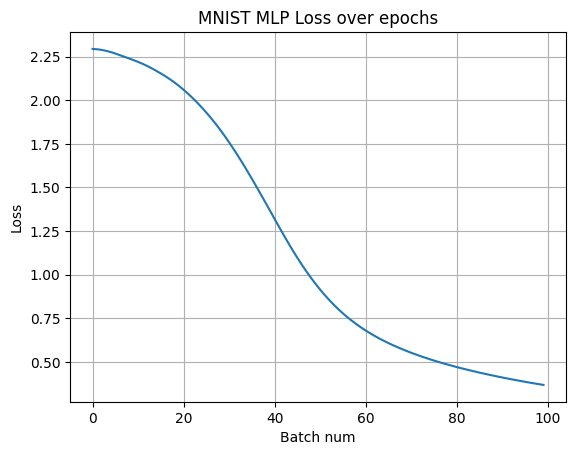

In [33]:
# Train Baseline Model
if not eval_mode:
    baseline_model_trained = train_baseline_model(baseline_model, trainloader, num_epochs=100)
    save_model(baseline_model_trained, baseline_model_path)
else:
    baseline_model_trained = load_model(baseline_model, baseline_model_path)


100%|██████████| 300/300 [01:51<00:00,  2.68it/s]


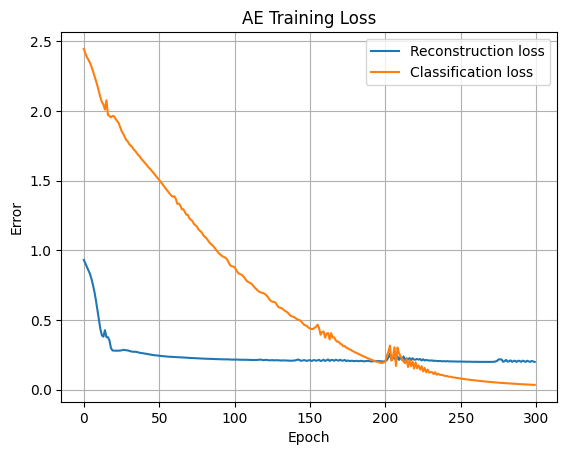

In [34]:
# Train OSR Model
if not eval_mode:
    OSR_model_trained = train_OSR_model(num_epochs=num_epochs)
    save_model(OSR_model_trained, osr_model_path)
else:
    OSR_model_trained = load_model(ML_autoencoder_OSR(), osr_model_path)

## Evalutation

Accuracy of OSR Model only on MNIST:

In [35]:
def eval_baseline(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in testloader:
            data, labels = data.view(data.size(0), -1).to(device), labels.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Create a DataLoader for only the MNIST test set
mnist_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Evaluate the model on MNIST only
acc_mnist_only = eval_baseline(baseline_model_trained, mnist_loader, device)

# Print the results
print(f"Accuracy on MNIST only: {acc_mnist_only:.2%}")

Accuracy on MNIST only: 86.25%


Accuracy of OSR Model on the combined data set:

In [36]:
osr_loader = DataLoader(combined_ds, batch_size=1024, shuffle=False) #this combined_ds contains also the testset use to evaluate the baseline model

threshold = 0.1  # Set a suitable threshold based on training reconstruction errors

acc_mnist, acc_ood, acc_total = eval_model(OSR_model_trained, osr_loader, device, threshold)

print(f"Accuracy on MNIST in OSR: {acc_mnist:.2%}")
print(f"Accuracy on OOD in OSR: {acc_ood:.2%}")
print(f"Total Accuracy in OSR: {acc_total:.2%}")


Accuracy on MNIST in OSR: 4.94%
Accuracy on OOD in OSR: 99.88%
Total Accuracy in OSR: 68.23%
